# Linear sweep voltammetry (LSV)
Peter Attia, May 17 2020

This notebook plots the first lithiation of carbon black electrodes as a function of sweep rate.

In [1]:
import re
import glob
from pathlib import Path

import numpy as np
from scipy.signal import savgol_filter
from scipy.integrate import cumtrapz
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Load data

In [3]:
file_list = sorted(list((Path.cwd()).glob('*.txt')))
file_list

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellE_CB_LSV_3mVpermin_CB1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellF_CB_LSV_10mVpermin_CB2.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellG_CB_LSV_30mVpermin_CB3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellH_CB_LSV_100mVpermin_CB4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellI_CB_LSV_300mVpermin_CB5.txt')]

In [4]:
masses = [0.8, 0.8, 0.8, 0.8, 0.8] # mg. Nominal values (true values were unavailable)

#### Sanity check dVdt values

3 -3.000445268594945 0.6090303352423291 -0.20297998487655372
10 -10.002255003113708 0.5378946798955853 -0.0537773411823772
30 -29.939482586270127 1.5046745942106194 -0.05025720100121718
100 -100.02010430021092 0.6232664014496389 -0.006231411232874754
300 -300.05609981459264 0.7598870161055383 -0.002532483147568336


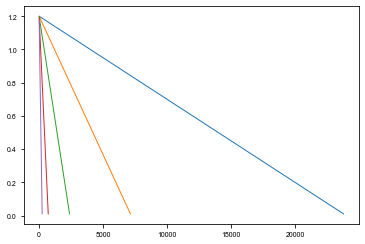

In [5]:
for k, file in enumerate(file_list):
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    
    UCV = 1.2
    idx1 = np.where(data[:,2] < UCV)[0][0]
    data = data[idx1:]
    idx2 = np.where(data[:,0] == 1)[0][0]
    data = data[:idx2]
    
    dVdt = np.gradient(data[:,2] * 1000) / np.gradient(data[:,1] / 60) # V/s -> mV/min
    
    mean = np.mean(dVdt)
    std = np.std(dVdt)
    print(speed , mean, std, std/mean)
    
    plt.plot(data[:,1] - data[0,1], data[:,2])

## Compare to galvanostatic experiments

Code adapted from C rate notebook

### Load metadata

In [6]:
metadata = pd.read_csv(Path.cwd().parent / 'c rate' / 'masses.csv')
metadata

,File name,Mass (mg),C rate
0,cellA_Cover100_split_CA1,0.977,0.010000
1,cellA_Cover100_CC4,0.548,0.010000
2,cellC_Cover30_split_CC5,0.914,0.033333
3,cellD_Cover30_CC6,0.845,0.033333
4,cellA_Cover10_CC7,0.776,0.100000
5,cellE_Cover3_split_CC8,0.809,0.333333
6,cellC_Cover3_CF6,0.583,0.333333
7,cellG_1C_split_CD3,0.468,1.000000
8,cellM_1C_CD5,0.743,1.000000
9,cellF_3C_split_CF6,1.011,3.000000


### Load constant current data
Get data:

In [7]:
files_constcurr = list((Path.cwd().parent / 'c rate' / 'constant current data').glob('*.txt'))
files_constcurr

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover100_CC4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellJ_3C_CD8.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellM_1C_CD5.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_Cover3_CF6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellD_Cover30_CC6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_10C_CF3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover10_CC7.txt')]

Parse and process:

In [8]:
all_data_constcurr = {}

for file in files_constcurr:
    
    sub_dict = {}
    
    # C rate parsing
    C_rate = int(re.findall(r'\d+', file.name.split('_')[1])[0])
    C_rate_string = file.name.split('_')[1].replace('over', '/')
    
    if 'Cover' in file.name:
        C_rate = 1 / C_rate
    
    # Logging
    print(f'{file.stem}: {C_rate}, {C_rate_string}')
    
    # Load data
    data = np.loadtxt(file, skiprows=1)
    
    # Get mass
    mass = metadata[metadata['File name'] == file.stem]['Mass (mg)'].iloc[0] / 1000 # mg -> g
    
    # Normalize capacity by mass
    data[:, 2] = data[:, 2] / mass # mAh -> mAh/g
    
    # Index different cycle numbers
    first_lith_idx = np.where(data[:, 0] == 1)[0][0]
    second_cycle_idx = np.where(data[:, 0] == 2)[0][0]
    second_lith_idx = first_lith_idx + np.where(data[first_lith_idx:second_cycle_idx, 1] == np.max(data[first_lith_idx:second_cycle_idx, 1]))[0][0]
    try:
        third_cycle_idx = np.where(data[:, 0] == 3)[0][0]
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:third_cycle_idx, 1] == np.max(data[second_cycle_idx:third_cycle_idx, 1]))[0][0]
    except IndexError: # 10C data has only 2 cycles
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:, 1] == np.max(data[second_cycle_idx:, 1]))[0][0]
    
    # Extract (de)lith steps
    first_lith_data = data[:first_lith_idx]
    
    # Create dictionary    
    sub_dict['First lith data'] = first_lith_data
    sub_dict['C rate'] = C_rate
    sub_dict['C rate string'] = C_rate_string
        
    # Append to main dictionary. We only want the high-rate data in this case tho
    if C_rate > 0.9:
        all_data_constcurr[file.stem] = sub_dict

# Sort
all_data_constcurr = {k: v for k, v in sorted(all_data_constcurr.items(), key=lambda item: item[1]['C rate'])}

cellA_Cover100_CC4: 0.01, C/100
cellJ_3C_CD8: 3, 3C
cellM_1C_CD5: 1, 1C
cellC_Cover3_CF6: 0.3333333333333333, C/3
cellD_Cover30_CC6: 0.03333333333333333, C/30
cellC_10C_CF3: 10, 10C
cellA_Cover10_CC7: 0.1, C/10


## Create plot

Starting cellE_CB_LSV_3mVpermin_CB1
3 0.7793227066666666 -0.12296656898809522
Starting cellF_CB_LSV_10mVpermin_CB2
10 0.6993227066666665 -0.3342125732142856
Starting cellG_CB_LSV_30mVpermin_CB3
30 0.630229116190476 -0.9214879970238092
Starting cellH_CB_LSV_100mVpermin_CB4
100 0.39215571 -2.01690925
Starting cellI_CB_LSV_300mVpermin_CB5
300 0.22620249 -6.099876749999999


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


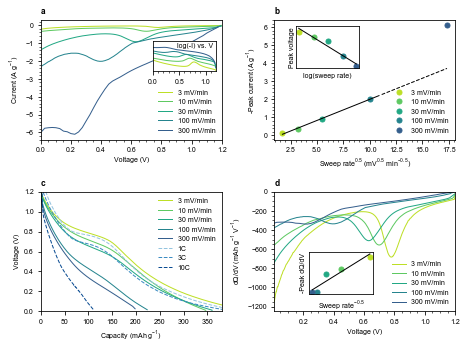

In [9]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*2), nrows=2, ncols=2)
ax = ax.ravel()

# Set main axes labels
for k in np.arange(len(ax)):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')

# Plot settings
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Sweep rate$^{0.5}$ (mV$^{0.5}$ min$^{-0.5}$)')
ax[2].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[3].set_xlabel('Voltage (V)')

ax[0].set_ylabel('Current (A g$^{-1}$)')
ax[1].set_ylabel('-Peak current (A g$^{-1}$)')
ax[2].set_ylabel('Voltage (V)')
ax[3].set_ylabel('dQ/dV (mAh g$^{-1}$ V$^{-1}$)')

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_xlim([0, 1.2])
ax[2].set_xlim([0, 380])
ax[2].set_ylim([0, 1.2])
ax[3].set_xlim([0.01, 1.2])
ax[3].set_ylim([-1250, 0])


ax_inset0 = inset_axes(ax[0], width='100%', height='100%',
                       bbox_to_anchor=(0.6, 0.6, 0.35, 0.25),
                       bbox_transform=ax[0].transAxes,
                       loc='upper left')
ax_inset1 = inset_axes(ax[1], width='100%', height='100%',
                       bbox_to_anchor=(0.1, 0.625, 0.35, 0.35),#(0.625, 0.15, 0.35, 0.35),
                       bbox_transform=ax[1].transAxes,
                       loc='upper left')
ax_inset3 = inset_axes(ax[3], width='100%', height='100%',
                       bbox_to_anchor=(0.175, 0.175, 0.35, 0.35),
                       bbox_transform=ax[3].transAxes,
                       loc='upper left')

ax_inset0.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset1.yaxis.set_minor_locator(AutoMinorLocator())
ax_inset3.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset3.yaxis.set_minor_locator(AutoMinorLocator())

ax_inset0.set_xlim([0, 1.2])
ax_inset0.set_ylim([1e-2, 30])

ax_inset1.set_xlabel('log(sweep rate)')
#ax_inset1.set_ylabel('$V_{peak}$ (V)', labelpad=0.8)
ax_inset1.set_ylabel('Peak voltage', labelpad=0.8)
ax_inset3.set_xlabel('Sweep rate$^{-0.5}$')
ax_inset3.set_ylabel('-Peak dQ/dV')


speeds = np.zeros((len(file_list), ))
E_peaks = np.zeros((len(file_list), ))
I_peaks = np.zeros((len(file_list), ))
dQdV_peaks = np.zeros((len(file_list), ))


colors = cm.viridis(np.linspace(0.9, 0.3, 5))[:,0:3]
colors_constcurr  = cm.Blues( np.linspace(0.4, 0.9, len(all_data_constcurr.items())))[:,0:3]


for k, file in enumerate(file_list):
    
    print(f'Starting {file.stem}')
    
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    
    # Filter relevant data
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    
    # Get first LSV sweep between UCV and end of negative sweep
    UCV = 1.2
    idx1 = np.where(data[:,2] < UCV)[0][0]
    data = data[idx1:]
    idx2 = np.where(data[:,0] == 1)[0][0]
    data = data[:idx2]
    
    # Get mass
    m = masses[k]
    
    # Get columns
    redox = data[:,0]
    time = (data[:,1] - data[0,1]) / 3600
    voltage = data[:,2]
    current = data[:,3] / m
    
    # Numerically integrate
    Q = 1000 * cumtrapz(y=-current, x=time) # mAh/mg -> mAh/g
    
    # Light smoothing
    if speed < 31:
        voltage = savgol_filter(voltage, 21, 1)
        current = savgol_filter(current, 21, 1)
        
    # Get dQ/dV
    dQdV = current / speed
    dQdV_derivative = np.gradient(Q, voltage[:-1])
    
    
    # Find index of peak current > 0.2 V
    idx_0pt2V = np.where(voltage < 0.2)[0][0]
    max_idx = np.where(current[:idx_0pt2V] == np.min(current[:idx_0pt2V]))[0][0]
    E_peak = voltage[max_idx]
    I_peak = current[max_idx]
    dQdV_peak = dQdV[max_idx]
    print(speed, E_peak, I_peak)
    
    # Speeds/peaks
    speeds[k] = speed 
    E_peaks[k] = E_peak
    I_peaks[k] = I_peak
    dQdV_peaks[k] = dQdV_peak
    
    # Plot
    ax[0].plot(voltage, current, color=colors[k],
            label=str(speed) + ' mV/min')
    ax[1].plot(speed**0.5, -I_peak, 'o', color=colors[k],
               label=str(speed) + ' mV/min')
    ax[2].plot(Q, voltage[:-1], color=colors[k],
            label=str(speed) + ' mV/min')
    ax[3].plot(voltage, 60 / 3.6 * 1000 * current / speed, color=colors[k],
              label=str(speed) + ' mV/min')
    
    # dQ/dV is numerically equivalent to current / sweep rate.
    # You can confirm this with below lines
    #ax[3].plot(voltage[:-1], dQdV_derivative, ':', color=colors[k],
    #          label=str(speed) + ' mV/min')
    
    ax_inset0.semilogy(voltage, -current, color=colors[k])
    ax_inset1.semilogx(speed, E_peak, 'o', color=colors[k])
    ax_inset3.plot(speed**-0.5, -dQdV_peak, 'o', color=colors[k],
                   label=str(speed) + ' mV/min')
    

# Add constant current V vs Q
for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    first_lith_data = value['First lith data']
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[2].plot(Q, V, '--', color=colors_constcurr[k], label=C_rate_string)
    

ax[0].legend(frameon=False)
ax[1].legend(frameon=False, loc='lower right')
ax[2].legend(frameon=False)
ax[3].legend(frameon=False)


ax_inset0.annotate('log(-I) vs. V', (0.95, 0.95), xycoords='axes fraction',
                   horizontalalignment='right', verticalalignment='top')

# Fits
speeds_logspace = np.logspace(np.log10(speeds[0]), np.log10(speeds[-1]), 100)

p1 = np.polyfit(speeds[:-1]**0.5, -I_peaks[:-1], 1)
p2 = np.polyfit(np.log10(speeds), E_peaks, 1)
p3 = np.polyfit(speeds**(-0.5), -dQdV_peaks, 1)

ax[1].plot(speeds_logspace[:-20]**0.5, p1[0]*speeds_logspace[:-20]**0.5 + p1[1], 'k')
ax[1].plot(speeds_logspace[-20:]**0.5, p1[0]*speeds_logspace[-20:]**0.5 + p1[1], '--', color='k')
ax_inset1.semilogx(speeds_logspace, p2[0]*np.log10(speeds_logspace) + p2[1], 'k')
ax_inset3.plot(speeds_logspace**(-0.5), p3[0]*speeds_logspace**(-0.5) + p3[1], 'k')

ax_inset0.get_yaxis().set_ticks([])
ax_inset1.get_xaxis().set_ticks([])
ax_inset1.minorticks_off()
ax_inset1.get_yaxis().set_ticks([])
ax_inset3.get_xaxis().set_ticks([])
ax_inset3.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig(figpath / 'LSVv2.eps', bbox_inches='tight', format='eps')